In [1]:
import os
import time
import vote
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from maverick import Maverick
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, confusion_matrix

2025-02-11 20:27:44.590620: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 20:27:44.670063: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-11 20:27:44.672976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 20:27:45.896806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
repo_dir = "../cic-iov-2024"
if not os.path.exists(repo_dir):
    !git clone https://github.com/val-co/cic-iov-2024.git

DATASET_DIRECTORY = '/home/ubuntu/Maverick/cic-iov-2024/'

In [3]:
# Dictionary to store dataframes
dataframes = {}
attack_labels = {}

# Loop through all files in the directory
for filename in os.listdir(DATASET_DIRECTORY):
    
    # Check if the file is a CSV
    if filename.endswith('.csv'):
        
        # Generate the variable name from the filename (remove '.csv')
        var_name = os.path.splitext(filename)[0]
        
        # Read the CSV file into a DataFrame
        file_path = os.path.join(DATASET_DIRECTORY, filename)
        dataframes[var_name] = pd.read_csv(file_path)
        
        # Create labels for each row based on the file name
        if 'SPEED' in var_name:
            label = 3
        elif 'GAS' in var_name:
            label = 2
        elif 'RPM' in var_name:
            label = 4
        elif 'STEERING_WHEEL' in var_name:
            label = 5
        elif 'DoS' in var_name:
            label = 6
        
        attack_labels[var_name] = [label] * len(dataframes[var_name])
        
        # Drop the last 2 columns
        dataframes[var_name] = dataframes[var_name].iloc[:, :-2]
        
        # Identify the third last column
        third_last_col = dataframes[var_name].columns[-1]
        
        # Replace values in the third last column
        dataframes[var_name][third_last_col] = dataframes[var_name][third_last_col].replace({'ATTACK': 1, 'BENIGN': 0})

# Optionally, print the variables to verify
for var_name, df in dataframes.items():
    print("DataFrame:",var_name)

DataFrame: decimal_spoofing-GAS
DataFrame: decimal_spoofing-SPEED
DataFrame: decimal_spoofing-RPM
DataFrame: decimal_spoofing-STEERING_WHEEL
DataFrame: decimal_DoS
DataFrame: decimal_benign


In [4]:
from sklearn.model_selection import train_test_split

test_df, test_l_df, train_df = {}, {}, {}

# Initialize empty DataFrames for combined datasets
X_train = pd.DataFrame()
X_surrogate = pd.DataFrame()
X_test = pd.DataFrame()

# Initialize empty Series for target variables
y_train = pd.Series(dtype='int')
y_surrogate = pd.Series(dtype='int')
y_test = pd.Series(dtype='int')

# Split each DataFrame and combine the splits
for var_name, df in dataframes.items():
    X = df.iloc[:, :-1]  # All columns except the last one
    y = df.iloc[:, -1]   # The last column
    
    X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_surrogate_temp, X_test_temp, y_surrogate_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    train_df[var_name] = X_train_temp
    
    test_df[var_name] = X_test_temp
    test_l_df[var_name] = y_test_temp
    
    # Combine the splits into the respective datasets
    X_train = pd.concat([X_train, X_train_temp])
    X_surrogate = pd.concat([X_surrogate, X_surrogate_temp])
    X_test = pd.concat([X_test, X_test_temp])
    
    y_train = pd.concat([y_train, y_train_temp])
    y_surrogate = pd.concat([y_surrogate, y_surrogate_temp])
    y_test = pd.concat([y_test, y_test_temp])

# Optionally, print the shapes of the combined datasets to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print()
print(f"X_surrogate shape: {X_surrogate.shape}")
print(f"y_surrogate shape: {y_surrogate.shape}")
print()
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (844929, 9)
y_train shape: (844929,)

X_surrogate shape: (281643, 9)
y_surrogate shape: (281643,)

X_test shape: (281647, 9)
y_test shape: (281647,)


##### Then we visualise some of the data

In [ ]:
from collections import Counter

print(X_train.head())
Counter(y_train)

       ID  DATA_0  DATA_1  DATA_2  DATA_3  DATA_4  DATA_5  DATA_6  DATA_7
4514  513       0       0       0       0       0       0       0     125
3729  513       0       0       0       0       0       0       0     125
6199  513       0       0       0       0       0       0      64     156
1612  513       0       0       0       0       0       0       0     125
1181  513       0       0       0       0       0       0       0     125


Counter({1: 110687, 0: 734242})

##### Then we train a Random Forest or XGBoost Classifier

In [6]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
model1.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=254, random_state=42)

In [7]:
ypred = model1.predict(X_test)
print("Accuracy: ", accuracy_score(ypred, y_test), "\n")
tn, fp, fn, tp = confusion_matrix(ypred, y_test).ravel()
tpr = tp / (tp + fn)  # True positive rate
tnr = tn / (tn + fp)  # True negative rate
fpr = fp / (fp + tn)  # False positive rate
fnr = fn / (fn + tp)  # False negative rate
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Accuracy:  1.0 

True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


##### Then we train a surrogate model

In [6]:
model2 = RandomForestClassifier(n_estimators=254, max_depth=10, random_state=42)
model2.fit(X_surrogate, y_surrogate)

RandomForestClassifier(max_depth=10, n_estimators=254, random_state=42)

In [9]:
ypred = model2.predict(X_test)
print("Accuracy: ", accuracy_score(ypred, y_test), "\n")
tn, fp, fn, tp = confusion_matrix(ypred, y_test).ravel()
tpr = tp / (tp + fn)  # True positive rate
tnr = tn / (tn + fp)  # True negative rate
fpr = fp / (fp + tn)  # False positive rate
fnr = fn / (fn + tp)  # False negative rate
print(f"True Positive Rate (TPR): {tpr:.3f}")
print(f"True Negative Rate (TNR): {tnr:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")
print(f"False Negative Rate (FNR): {fnr:.3f}")

Accuracy:  1.0 

True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


In [7]:
X_benign = []

##### Now, we generate adversarial examples for the 'decimal_spoofing-GAS' scenario

In [8]:
%%script echo skipping

A_spoof_gas, L_spoof_gas, L_spoof_gas_extended = [], [], []

datas = test_df['decimal_spoofing-GAS']
labels = test_l_df['decimal_spoofing-GAS']

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

print('Finding Adversarial Examples')
e = vote.Ensemble.from_sklearn(model2)
deltas = [0, 15, 15, 15, 15, 15, 15, 15, 15] 

for i in tqdm(range(len(labels))):
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, labels.iloc[i])
        if o == vote.FAIL:
            center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / 2 for dim in range(m.nb_inputs)]
            if(model1.predict([center]) != labels.iloc[i]):
                A_spoof_gas.append(center)
                L_spoof_gas.append(labels.iloc[i])
                L_spoof_gas_extended.append(attack_labels['decimal_spoofing-GAS'][i])
                X_benign.append(datas.iloc[i])
        return o
    
    domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
    e.absref(check_robustness, domain)

y_pred = model1.predict(A_spoof_gas)
print('Adversarial Examples Found: ', len(A_spoof_gas))
print("Accuracy on Adversarial Examples: ", accuracy_score(y_pred, L_spoof_gas))

Finding Adversarial Examples


100%|██████████| 1999/1999 [00:20<00:00, 96.99it/s] 

Adversarial Examples Found:  962
Accuracy on Adversarial Examples:  0.0


##### Now, we generate adversarial examples for the 'decimal_spoofing-SPEED' scenario

In [9]:
%%script echo skipping

A_spoof_speed, L_spoof_speed, L_spoof_speed_extended = [], [], []

datas = test_df['decimal_spoofing-SPEED']
labels = test_l_df['decimal_spoofing-SPEED']

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

print('Finding Adversarial Examples')
e = vote.Ensemble.from_sklearn(model2)
deltas = [0, 15, 15, 15, 15, 15, 15, 15, 15]

for i in tqdm(range(len(labels))):
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, labels.iloc[i])
        if o == vote.FAIL:
            center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / 2 for dim in range(m.nb_inputs)]
            if(model1.predict([center]) != labels.iloc[i]):
                A_spoof_speed.append(center) 
                L_spoof_speed.append(labels.iloc[i])
                L_spoof_speed_extended.append(attack_labels['decimal_spoofing-SPEED'][i])
                X_benign.append(datas.iloc[i])
        return o
    
    domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
    e.absref(check_robustness, domain)

y_pred = model1.predict(A_spoof_speed)
print('Adversarial Examples Found: ', len(A_spoof_speed))
print("Accuracy on Adversarial Examples: ", accuracy_score(y_pred, L_spoof_speed)) 

Finding Adversarial Examples


  0%|          | 0/4991 [00:00<?, ?it/s]

100%|██████████| 4991/4991 [01:28<00:00, 56.54it/s]

Adversarial Examples Found:  2962
Accuracy on Adversarial Examples:  0.0


##### Now, we generate adversarial examples for the 'decimal_spoofing-RPM' scenario

In [10]:
%%script echo skipping

A_spoof_rpm, L_spoof_rpm, L_spoof_rpm_extended = [], [], [] 

datas = test_df['decimal_spoofing-RPM'] 
labels = test_l_df['decimal_spoofing-RPM'] 

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

print('Finding Adversarial Examples')
e = vote.Ensemble.from_sklearn(model2)
deltas = [0, 0, 0, 15, 15, 0, 14, 0, 14] 

for i in tqdm(range(len(labels))):
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, labels.iloc[i])
        if o == vote.FAIL:
            center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / 2 for dim in range(m.nb_inputs)]
            if(model1.predict([center]) != labels.iloc[i]):
                A_spoof_rpm.append(center)
                L_spoof_rpm.append(labels.iloc[i])
                L_spoof_rpm_extended.append(attack_labels['decimal_spoofing-RPM'][i])
                X_benign.append(datas.iloc[i])
        return o
    
    domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
    e.absref(check_robustness, domain)

y_pred = model1.predict(A_spoof_rpm)
print('Adversarial Examples Found: ', len(A_spoof_rpm))
print("Accuracy on Adversarial Examples: ", accuracy_score(y_pred, L_spoof_rpm))

Finding Adversarial Examples


100%|██████████| 10980/10980 [00:41<00:00, 261.64it/s]


Adversarial Examples Found:  2027
Accuracy on Adversarial Examples:  0.0


##### Now, we generate adversarial examples for the 'decimal_spoofing-STEERING_WHEEL' scenario

In [11]:
%%script echo skipping

A_spoof_steering_wheel, L_spoof_steering_wheel, L_spoof_steering_wheel_extended = [], [], []

datas = test_df['decimal_spoofing-STEERING_WHEEL']
labels = test_l_df['decimal_spoofing-STEERING_WHEEL']

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

print('Finding Adversarial Examples')
e = vote.Ensemble.from_sklearn(model2)
deltas = [0, 17, 17, 17, 17, 17, 17, 17, 17]

for i in tqdm(range(len(labels))):
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, labels.iloc[i])
        if o == vote.FAIL:
            center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / 2 for dim in range(m.nb_inputs)]
            if(model1.predict([center]) != labels.iloc[i]): 
                A_spoof_steering_wheel.append(center)
                L_spoof_steering_wheel.append(labels.iloc[i])
                L_spoof_steering_wheel_extended.append(attack_labels['decimal_spoofing-STEERING_WHEEL'][i]) 
                X_benign.append(datas.iloc[i]) 
        return o
    
    domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
    e.absref(check_robustness, domain)

y_pred = model1.predict(A_spoof_steering_wheel)    
print('Adversarial Examples Found: ', len(A_spoof_steering_wheel))
print("Accuracy on Adversarial Examples: ", accuracy_score(y_pred, L_spoof_steering_wheel))

Finding Adversarial Examples


100%|██████████| 3996/3996 [01:41<00:00, 39.20it/s]

Adversarial Examples Found:  2005
Accuracy on Adversarial Examples:  0.0


##### Now, we generate adversarial examples for the 'decimal_DoS' scenario

In [12]:
%%script echo skipping

A_dos, L_dos, L_dos_extended = [], [], []

datas = test_df['decimal_DoS'] 
labels = test_l_df['decimal_DoS']

def label_checker(expected, mapping):
    return vote.mapping_check_argmax(mapping, expected)

print('Finding Adversarial Examples')
e = vote.Ensemble.from_sklearn(model2)
deltas = [7, 0, 15, 15, 15, 15, 15, 15, 15]

for i in tqdm(range(len(labels))):
    def check_robustness(m):
        o = vote.mapping_check_argmax(m, labels.iloc[i])
        if o == vote.FAIL:
            center = [m.inputs[dim].lower + (m.inputs[dim].upper - m.inputs[dim].lower) / 2 for dim in range(m.nb_inputs)]
            if(model1.predict([center]) != labels.iloc[i]):
                A_dos.append(center)
                L_dos.append(labels.iloc[i])
                L_dos_extended.append(attack_labels['decimal_DoS'][i])
                X_benign.append(datas.iloc[i])
        return o
    
    domain = [(max(x - delta, 0), min(2047, x + delta)) if idx == 0 else (max(x - delta, 0), min(255, x + delta)) for idx, (x, delta) in enumerate(zip(datas.iloc[i].values, deltas))]
    e.absref(check_robustness, domain)

y_pred = model1.predict(A_dos)
print('Adversarial Examples Found: ', len(A_dos)) 
print("Accuracy on Adversarial Examples: ", accuracy_score(y_pred, L_dos))

Finding Adversarial Examples


  0%|          | 0/14933 [00:00<?, ?it/s]

100%|██████████| 14933/14933 [05:17<00:00, 47.08it/s]

Adversarial Examples Found:  3944
Accuracy on Adversarial Examples:  0.0


##### Then we combine all these adversarial datasets

In [15]:
%%script echo skipping

true_labels = np.concatenate((L_spoof_gas, L_spoof_speed, L_spoof_rpm, L_spoof_steering_wheel, L_dos))
adversarial_examples = np.concatenate((A_spoof_gas, A_spoof_speed, A_spoof_rpm, A_spoof_steering_wheel, A_dos))
true_labels_extended = np.concatenate((L_spoof_gas_extended, L_spoof_speed_extended, L_spoof_rpm_extended, L_spoof_steering_wheel_extended, L_dos_extended))

y_pred = model1.predict(adversarial_examples)
print("Accuracy on the Adversarial Set: ", accuracy_score(y_pred, true_labels))
print(Counter(true_labels_extended))

skipping


##### Then we save these datasets to disk

In [16]:
%%script echo skipping

np.save('benign_samples.npy', X_benign)
np.save('true_labels_std.npy', true_labels)
np.save('adversarial_examples_std.npy', adversarial_examples)
np.save('true_labels_std_extended.npy', true_labels_extended)

skipping


##### Then we retrieve them from disk

In [7]:
import numpy as np

X_benign = np.load('benign_samples.npy')
true_labels = np.load('true_labels_std.npy')
adversarial_examples = np.load('adversarial_examples_std.npy')
true_labels_extended = np.load('true_labels_std_extended.npy')

##### Then we select random samples from the test set

In [10]:
random.seed(42)

num_samples = len(adversarial_examples)

selected_indices = random.sample(range(len(X_test)), num_samples)

X_selected = X_test.iloc[selected_indices].values
y_selected = y_test.iloc[selected_indices].values

In [11]:
test_set = np.concatenate((X_selected, adversarial_examples))
test_lab_sym = np.concatenate((np.zeros(len(y_selected), dtype=bool), np.ones(len(true_labels), dtype=bool)))

test_lab = np.concatenate((y_selected, true_labels))

print("Evaluation Samples:", len(test_set))

Evaluation Samples: 23800


In [6]:
def convert(number, unit='micro'):
    if unit == 'micro':
        result = number * 1e6
    elif unit == 'milli':
        result = number * 1e3
    elif unit == 'nano':
        result = number * 1e9
    else:
        raise ValueError("Invalid unit. Choose from 'micro', 'milli', or 'nano'.")
    return round(result, 3)

##### Then we create Maverick and compare its performance!

In [10]:
mav = Maverick(model1, X_train, y_train, save_filename = "autoencoder_standard_new.h5")

Initializing Maverick...
Loading File: autoencoder_standard_new.h5
Initialization Complete!


In [9]:
mav = Maverick(model1, load_filename="autoencoder_standard_new.h5")

Initializing Maverick...
Loading File: autoencoder_standard_new.h5
Initialization Complete!


By default, the initialization process saves the autoencoder within Maverick as "autoencoder_model.h5". We can then retrieve it from disk! 

93/93 [==============================] - 1s 7ms/step


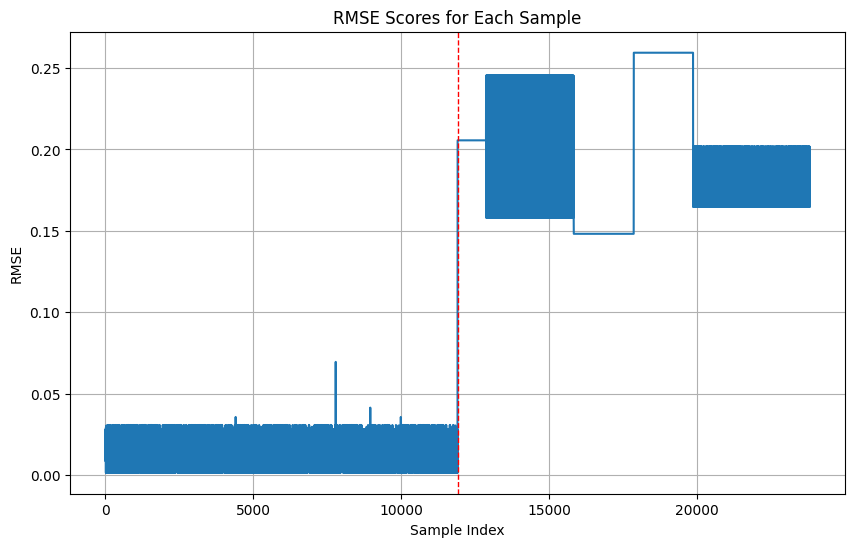

In [23]:
mav.plot_rmse_scores(test_set, test_lab_sym)

In [24]:
mav.get_metrics(test_set, test_lab, threshold=0.10)

11/93 [==>...........................] - ETA: 0s

93/93 [==============================] - 1s 5ms/step
Maverick Average Prediction Time:  77.873 μs

Accuracy:  1.0
F1-Score:  1.0
MCC:  1.0
True Positive Rate (TPR): 1.000
True Negative Rate (TNR): 1.000
False Positive Rate (FPR): 0.000
False Negative Rate (FNR): 0.000


In [7]:
X_train_attack = pd.concat([train_df['decimal_spoofing-GAS'], train_df['decimal_spoofing-SPEED'], 
                            train_df['decimal_spoofing-RPM'], train_df['decimal_spoofing-STEERING_WHEEL'], 
                            train_df['decimal_DoS']])

y_train_attack = np.concatenate([np.full(len(train_df['decimal_spoofing-GAS']), np.unique(attack_labels['decimal_spoofing-GAS'])),
                                 np.full(len(train_df['decimal_spoofing-SPEED']), np.unique(attack_labels['decimal_spoofing-SPEED'])),
                                 np.full(len(train_df['decimal_spoofing-RPM']), np.unique(attack_labels['decimal_spoofing-RPM'])),
                                 np.full(len(train_df['decimal_spoofing-STEERING_WHEEL']), np.unique(attack_labels['decimal_spoofing-STEERING_WHEEL'])),
                                 np.full(len(train_df['decimal_DoS']), np.unique(attack_labels['decimal_DoS']))])

print(X_train_attack.shape, y_train_attack.shape)

(110687, 9) (110687,)


## Detecting the attacker's intentions!

In [34]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

autoencoder_dir = "autoencoders"
os.makedirs(autoencoder_dir, exist_ok=True)

label_autoencoders_file = os.path.join(autoencoder_dir, 'label_autoencoders.pkl')
label_autoencoders = {}

if os.path.exists(label_autoencoders_file):
    @tf.keras.utils.register_keras_serializable(package="Custom")
    def rmse_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32) 
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    with open(label_autoencoders_file, 'rb') as f:
        label_autoencoders = pickle.load(f)
else:
    scaler = MinMaxScaler()
    X_train_attack_ = scaler.fit_transform(X_train_attack)

    input_dim = X_train_attack.shape[1]
    encoded_dim = 2

    def build_autoencoder(input_dim, encoded_dim):
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoded_dim, activation='relu')(input_layer)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        return autoencoder

    def rmse_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32) 
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    unique_labels = np.unique(y_train_attack)
    label_autoencoders = {}
    histories = {}

    for label in unique_labels:
        print(f"Training autoencoder for label {label}")
        label_data = X_train_attack_[y_train_attack == label]
        autoencoder = build_autoencoder(input_dim, encoded_dim)
        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

        # Set up EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

        history = autoencoder.fit(
            label_data, label_data, 
            epochs=250,
            batch_size=256,
            shuffle=True,
            validation_split=0.1,
            callbacks=[early_stopping]
        )

        label_autoencoders[label] = autoencoder
        histories[label] = history

    with open(os.path.join(autoencoder_dir, 'label_autoencoders.pkl'), 'wb') as f:
        pickle.dump(label_autoencoders, f)



In [71]:
unique_labels = np.unique(y_train_attack)

scaler_adv = MinMaxScaler()
adversarial_examples_ = scaler_adv.fit_transform(adversarial_examples) 

all_losses = []
for label in unique_labels:
    autoencoder = label_autoencoders[label]
    reconstructed = autoencoder.predict(adversarial_examples_, batch_size=256)
    losses = np.sqrt(np.mean((adversarial_examples_ - reconstructed) ** 2, axis=1))
    all_losses.append(losses)

all_losses_ = np.array(all_losses).T  # Shape: (num_examples, num_labels)
predicted_labels = unique_labels[np.argmin(all_losses_, axis=1)]  # Label with lowest loss per example

47/47 [==============================] - 0s 2ms/step


In [72]:
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score

precision = precision_score(true_labels_extended, predicted_labels, average='macro') 
recall = recall_score(true_labels_extended, predicted_labels, average='macro') 
f1 = f1_score(true_labels_extended, predicted_labels, average='macro') 
balanced_acc = balanced_accuracy_score(true_labels_extended, predicted_labels)

print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Precision (macro-average): {precision:.3f}")
print(f"Recall (macro-average): {recall:.3f}")
print(f"F1 Score (macro-average): {f1:.3f}")


Balanced Accuracy: 0.933
Precision (macro-average): 0.960
Recall (macro-average): 0.933
F1 Score (macro-average): 0.938


# Tuning the ratio of Adversarial:Non-Adversarial Samples for Evaluation

In [33]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score, matthews_corrcoef, roc_auc_score
import plotly.graph_objects as go

from plotly.subplots import make_subplots

random.seed(42)
np.random.seed(42)

dataset_name = 'CIC-IoV-2024'

num_samples = len(adversarial_examples)
selected_indices = random.sample(range(len(X_test)), num_samples)

X_test_ = X_test.iloc[selected_indices].values
y_test_ = y_test.iloc[selected_indices].values

# Ratios to analyze
ratios = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Metrics storage
mcc_list, f1score_list, precision_list, recall_list, fpr_list, fnr_list, accuracy_list, auc_list = [], [], [], [], [], [], [], []
ratio_labels = []

for adv_count in ratios:

    # Sampling with fixed seed
    np.random.seed(42)

    # Sample the indices for original and adversarial examples based on the desired ratio
    adv_indices = np.random.choice(len(adversarial_examples), math.ceil((adv_count/100)*len(adversarial_examples)), replace=False)

    np.random.seed(42)
    remove_indices = np.random.choice(len(X_test_), len(adv_indices), replace=False)
    X_test__ = np.delete(X_test_, remove_indices, axis=0)
    y_test__ = np.delete(y_test_, remove_indices, axis=0)
    
    # Combine the data
    combined_data = np.vstack((X_test__, adversarial_examples[adv_indices]))
    combined_labels = np.hstack((y_test__, true_labels[adv_indices]))

    print("Ratio (Adv : Non-Adv) -", len(adversarial_examples[adv_indices]), len(X_test__))

    # Calculate and print ratio
    r = adv_count
    ratio_labels.append(f"{r}:{100-r}")  # Corrected formatting

    # Predictions
    predictions = mav.predict(pd.DataFrame(combined_data, columns=X_test.columns), threshold=0.09)

    # Metrics
    mcc = matthews_corrcoef(combined_labels, predictions)
    f1score = f1_score(combined_labels, predictions)
    precision = precision_score(combined_labels, predictions)
    recall = recall_score(combined_labels, predictions)
    accuracy = accuracy_score(combined_labels, predictions)
    auc = roc_auc_score(combined_labels, predictions)

    TN, FP, FN, TP = confusion_matrix(combined_labels, predictions).ravel()
    fpr = FP / (FP + TN) 
    fnr = FN / (FN + TP)

    # Store metrics
    f1score_list.append(f1score)
    precision_list.append(precision)
    recall_list.append(recall)
    fpr_list.append(fpr)
    fnr_list.append(fnr)
    mcc_list.append(mcc)
    accuracy_list.append(accuracy)
    auc_list.append(auc)

Ratio (Adv : Non-Adv) - 0 11900
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 119 11781
47/47 [==============================] - 0s 6ms/step
Ratio (Adv : Non-Adv) - 238 11662
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 357 11543
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 476 11424
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 595 11305
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 714 11186
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 834 11066
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 952 10948
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 1071 10829
47/47 [==============================] - 0s 5ms/step
Ratio (Adv : Non-Adv) - 1190 10710
47/47 [==============================] - 0s 5ms/step


In [41]:
# Creating subplots
fig = make_subplots(
    rows=2, cols=4, 
    subplot_titles=("F1-Score", "Precision", "Recall", "Accuracy", "FPR", "FNR", "MCC", "AUC"),
    horizontal_spacing=0.03, vertical_spacing=0.12
)

# Adding traces
fig.add_trace(go.Scatter(x=ratio_labels, y=f1score_list, mode='lines+markers', name='F1-Score'), row=1, col=1)
fig.add_trace(go.Scatter(x=ratio_labels, y=precision_list, mode='lines+markers', name='Precision'), row=1, col=2)
fig.add_trace(go.Scatter(x=ratio_labels, y=recall_list, mode='lines+markers', name='Recall'), row=1, col=3)
fig.add_trace(go.Scatter(x=ratio_labels, y=accuracy_list, mode='lines+markers', name='Accuracy'), row=1, col=4)
fig.add_trace(go.Scatter(x=ratio_labels, y=fpr_list, mode='lines+markers', name='FPR'), row=2, col=1)
fig.add_trace(go.Scatter(x=ratio_labels, y=fnr_list, mode='lines+markers', name='FNR'), row=2, col=2)
fig.add_trace(go.Scatter(x=ratio_labels, y=mcc_list, mode='lines+markers', name='MCC'), row=2, col=3)
fig.add_trace(go.Scatter(x=ratio_labels, y=auc_list, mode='lines+markers', name='AUC'), row=2, col=4)

# Update layout
fig.update_layout(
    title={'text': f'Varying the ratio of Adversarial to Non-Adversarial Samples during Evaluation for {dataset_name} (X-axis: Adversarial:Non-Adversarial Ratio, Y-axis: Metric Value)', 'x': 0.5, 'xanchor': 'center'},
    height=300, width=950,
    showlegend=False,
    margin=dict(l=10, r=10, t=40, b=10),
    font=dict(size=8),  # General font size for axis text and other elements
)

# Update subplot titles font size
fig.update_layout(
    annotations=[dict(
        font=dict(size=9),  # Reduced font size for subplot titles
        xref="paper", yref="paper",
        showarrow=False
    ) for _ in range(8)]
)

eps = 0.05

fig.update_yaxes(range=[0, 1+eps], row=1, col=1, zeroline=True, dtick=0.25)
fig.update_yaxes(range=[0, 1+eps], row=1, col=2, zeroline=True, dtick=0.25)
fig.update_yaxes(range=[0, 1+eps], row=1, col=3, zeroline=True, dtick=0.25)
fig.update_yaxes(range=[0, 1+eps], row=1, col=4, zeroline=True, dtick=0.25)
fig.update_yaxes(range=[0-eps, 1], row=2, col=1, zeroline=False, dtick=0.25)
fig.update_yaxes(range=[0-eps, 1], row=2, col=2, zeroline=False, dtick=0.25)
fig.update_yaxes(range=[-1, 1+0.1], row=2, col=3, zeroline=False, dtick=0.50)
fig.update_yaxes(range=[0, 1+eps], row=2, col=4, zeroline=True, dtick=0.25)

# Increase the spacing between the graph and the ratio labels
fig.update_xaxes(linewidth=0.5, linecolor='pink', mirror=True, tickfont=dict(size=5), ticklabelposition="outside", ticklabelstandoff=2, dtick=0.1)
fig.update_yaxes(linewidth=0.5, linecolor='pink', mirror=True, tickfont=dict(size=5), ticklabelposition="outside", ticklabelstandoff=2)

fig.show()

In [42]:
fig.write_image("cic-vary.png", width=900, height=300, scale=5) 

In [43]:
from prettytable import PrettyTable

# Initialize table
table = PrettyTable()
table.field_names = ["Ratio", "F1-Score", "Precision", "Recall", "Accuracy", "FPR", "FNR", "MCC", "AUC"]

# Add rows with formatted values
for i in range(len(ratio_labels)):
    table.add_row([
        ratio_labels[i], 
        f"{f1score_list[i]:.3f}", f"{precision_list[i]:.3f}", f"{recall_list[i]:.3f}", 
        f"{accuracy_list[i]:.3f}", f"{fpr_list[i]:.3f}", f"{fnr_list[i]:.3f}", 
        f"{mcc_list[i]:.3f}", f"{auc_list[i]:.3f}"
    ])

# Print table
print(table)


+-------+----------+-----------+--------+----------+-------+-------+-------+-------+
| Ratio | F1-Score | Precision | Recall | Accuracy |  FPR  |  FNR  |  MCC  |  AUC  |
+-------+----------+-----------+--------+----------+-------+-------+-------+-------+
| 0:100 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.000 | 1.000 | 1.000 |
|  1:99 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.000 | 1.000 | 1.000 |
|  2:98 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.000 | 1.000 | 1.000 |
|  3:97 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.000 | 1.000 | 1.000 |
|  4:96 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.000 | 1.000 | 1.000 |
|  5:95 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.000 | 1.000 | 1.000 |
|  6:94 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.000 | 1.000 | 1.000 |
|  7:93 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.000 | 1.000 | 1.000 |
|  8:92 |  1.000   |   1.000   | 1.000  |  1.000   | 0.000 | 0.00